In [36]:
#this notebook is adapted from https://datalore.jetbrains.com/report/static/2jrFAfMBVhUsYW8njXgysC/9OuleGiEVhxqGen1GS9cjN?_ga=2.8213810.1854649308.1715236946-557222550.1715236946

In [37]:
#import needed modules

import numpy as np
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt
from PIL import Image, ImageChops

## Network initialization

In [38]:
#function to build a network
def build_network_demo(width=4, depth=4, variance=400, seed=42):
    if not (width > 0 and depth > 0 and variance > 0):
        #ensure valid parameters
        raise ValueError
    
    #to make network repeatable, we set a seed to generator
    tf.random.set_seed(seed)
    input_shape = (5,)  # number of parameters in input space defined above. x position, y position, alpha/beta for animation, and f for defining shape
    
    #specific initializer to ensure a pretty image. May be interesting to test others
    initializer = keras.initializers.VarianceScaling(scale=variance,
                                                     mode='fan_in',
                                                     distribution='normal',
                                                     seed=seed)
    #now we use Keras to build the network shape

    #first we set number of input parameters
    inputs = keras.Input(shape=input_shape)
    x = inputs

    #depth defines how many hidden layers the network will have betwee, its input and its output
    for _ in range(depth):
        #create a layer. It will have width outputs along with a tanh activation (output is squashed to -1 to 1)
        #num of inputs is determined automaticaly based on previous layer
        layer = keras.layers.Dense(width, kernel_initializer=initializer, activation='tanh')
        #add the layer to the network
        layer_output = layer(x)
        x = keras.layers.Concatenate()([x, layer_output])

    #add the final layer, which will output a single RGB value as the result
    bottleneck_initializer = keras.initializers.GlorotNormal(seed)
    bottleneck = keras.layers.Dense(3,  # The number of channels in RGB image
                                    activation='tanh',
                                    kernel_initializer=bottleneck_initializer)(x)
    
    #create a keras Model from the layers and return it
    model = keras.Model(inputs=inputs, outputs=bottleneck)
    return model

## Image size
Change the "res" value.


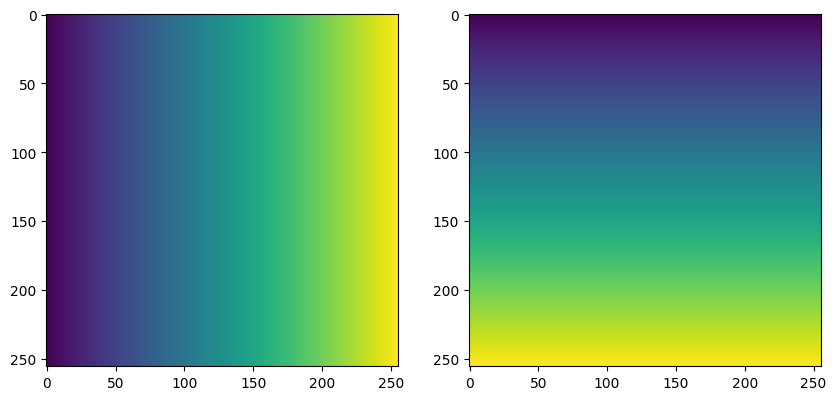

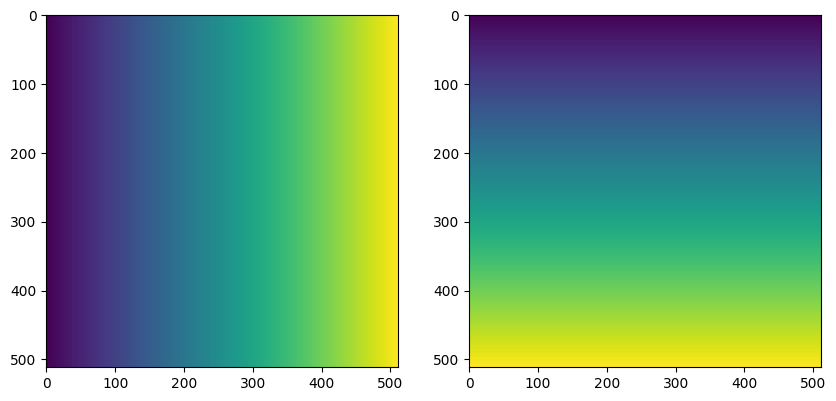

In [39]:
#lets build the input space. We need 5 "images", starting with encoding the image position
#use a square image of wished sizes
ress = [256, 512]

x_poss = []
y_poss = []

for res in ress:
  #get x values, linear from -1 to 1
  x_poss.append(np.linspace(-1,1,res))
  y_poss.append(np.linspace(-1,1,res))

  #expand the 1d arrays to two grids
  x_poss[len(x_poss) - 1], y_poss[len(y_poss) - 1] = np.meshgrid(x_poss[len(x_poss) - 1],y_poss[len(y_poss) - 1])

  #display the two images with plt
  plt.figure(figsize=(10,5))
  plt.subplot(1,2,1)
  plt.imshow(x_poss[len(x_poss) - 1])

  plt.subplot(1,2,2)
  plt.imshow(y_poss[len(y_poss) - 1])


In [40]:
#for now, alpha and beta are set to constant

alpha = 0.5
beta = 0.4

#expand for whole image

alphas_filled = []
betas_filled = []

for x_pos in x_poss:
  alphas_filled.append(np.full(x_pos.shape, alpha))
  betas_filled.append(np.full(x_pos.shape, beta))

  print(alphas_filled[len(alphas_filled) - 1].shape)
  print(betas_filled[len(betas_filled) - 1].shape)

(256, 256)
(256, 256)
(512, 512)
(512, 512)


## "Shape function" init

We can control the overall shape of the generated gradient using the f parameter.
If we map it to the distance from the center, it will result in a circular shape, but we can also use a diamond shape or just linearly along
the diagonal.

Comment out the f parameter.

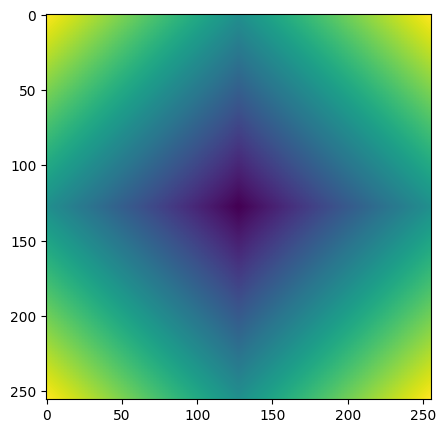

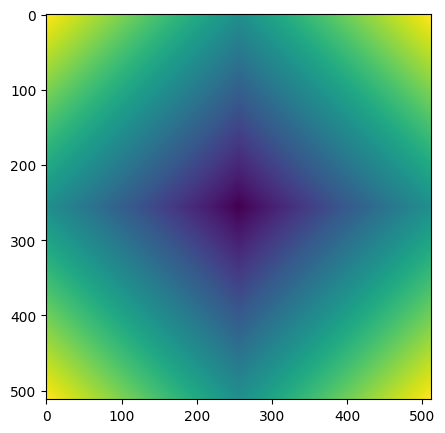

In [41]:
#define the f "shape function". Use a circular shape, meaning f will be distance from center

fs = []

for idx in range(len(x_poss)):
  #fs.append(np.sqrt(x_poss[idx] ** 2 + y_poss[idx] ** 2))

  #alternative: diamond shape
  fs.append(abs(x_poss[idx]) + abs(y_poss[idx]))

  #or just diagonal
  #fs.append(x_poss[idx] + y_poss[idx])


  plt.figure(figsize=(5,5))
  plt.imshow(fs[len(fs) - 1])

In [42]:
#reshape the 5 images into what our model expects: num_pixels batches of 5 values

batches = []

for idx in range(len(x_poss)):
  #flatten each of the images
  x_pos_flat = x_poss[idx].reshape(-1,1)
  y_pos_flat = y_poss[idx].reshape(-1,1)
  f_flat = fs[idx].reshape(-1,1)
  alpha_filled_flat = alphas_filled[idx].reshape(-1,1)
  beta_filled_flat = betas_filled[idx].reshape(-1,1)
  #concatenate into one array
  concat = np.array((x_pos_flat,y_pos_flat,alpha_filled_flat,beta_filled_flat,f_flat))

  print(concat.shape)

  #reshape: remove empty dim, ensure end result is res*res batches of 5 input values
  batches.append(np.concatenate(concat, axis=1))

  print(batches[len(batches) - 1].shape)
  print(batches[len(batches) - 1][0])


(5, 65536, 1)
(65536, 5)
[-1.  -1.   0.5  0.4  2. ]
(5, 262144, 1)
(262144, 5)
[-1.  -1.   0.5  0.4  2. ]


## Model complexity

The below code will initialize the model and calculate the final pattern. Change the depth/width/variance/seed parameters to generate different patterns.

Configure:
* depth/width: 1+; the bigger the number, more time it will take
* variance: up to approx. 10.000, but not really limited
* seed: any number

In [43]:
#network parameters. These increase the complexity of the model, which usually means more complex patterns
depth=10
width=4

#a lower variance will result in a smoother, more blurred image, while a higher one results in sharper edges
variance=10

#random seed. Changing the seed will result in a completely different pattern
seed=88


#initialize the model with the given parameters
model = build_network_demo(depth=depth, width=width, variance=variance, seed=seed)
#feed the data and save the resulting image into pred
preds = []
for batch in batches:
  preds.append(model.predict(batch)) 


2048/2048 ━━━━━━━━━━━━━━━━━━━━ 1s 663us/step
8192/8192 ━━━━━━━━━━━━━━━━━━━━ 5s 626us/step


# Normalize the result and display the image

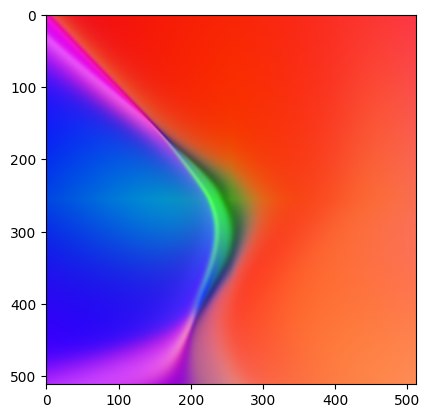

In [44]:
preds_normalized = []
for idx in range(len(preds)):
  preds_normalized.append((preds[idx]-preds[idx].min(0)) / (preds[idx].ptp(0) + 1e-10))
  plt.imshow(preds_normalized[len(preds_normalized) - 1].reshape(ress[idx],ress[idx],3))

## JetBrains recoloring code

Below is code that JetBrains used to recolor the random pattern into brand colors. Not sure exactly how it works,
or how to make it produce different colors.

In [45]:
color_params = {
    'grayscale_matrix': [0.3, 0.3, 0.3, 0.0, 0.3, 0.3, 0.3, 0.0, 0.3, 0.3, 0.3, 0.0],
    'red_component': [0, 0.11568627450980393, 0.3254901960784314, 0.23137254901960785, 0.4196078431372549,
                      0.027450980392156862, 1],
    'green_component': [0, 0.4588235294117647, 0.6294117647058823, 0.9176470588235294, 0.3411764705882353,
                        0.7647058823529411, 1],
    'blue_component': [0, 0.19215686274509805, 0.692156862745098, 0.3843137254901961, 1, 0.9490196078431372, 1],
    'color_matrix': [1.3935000000000002, -0.35750000000000004, -0.03599999999999999, 0,
                     -0.10650000000000001, 1.1425, -0.03599999999999999, 0,
                     -0.10650000000000001, -0.35750000000000004, 1.4640000000000002, 0]
}

def component_transfer(grayscale: np.ndarray, component: list) -> np.ndarray:
    n = len(component) - 1 

    def precompute_transfer(x):
        if x == 1:
            return component[-1]
        k = int(x * n)
        x_new = component[k] + (x - k / n) * n * (component[k + 1] - component[k])
        return round(x_new * 255)

    transfer_lookup = {x: precompute_transfer(x / 255) for x in range(256)}
    gradientmap = np.vectorize(transfer_lookup.get)(grayscale)
    return gradientmap

def recolor_image(source_img: Image) -> Image:
    grayscale = source_img.convert('RGB', color_params['grayscale_matrix'])
    grayscale_arr = np.array(grayscale)
    gradientmap_arr = np.zeros(grayscale_arr.shape, dtype=np.uint)
    gradientmap_arr[:, :, 0] = component_transfer(grayscale_arr[:, :, 0], color_params['red_component'])
    gradientmap_arr[:, :, 1] = component_transfer(grayscale_arr[:, :, 1], color_params['green_component'])
    gradientmap_arr[:, :, 2] = component_transfer(grayscale_arr[:, :, 2], color_params['blue_component'])
    gradientmap = Image.fromarray(gradientmap_arr.astype(np.uint8))
    blended = ImageChops.multiply(gradientmap, grayscale)
    result_img = blended.convert('RGB', color_params['color_matrix'])
    return result_img

## Simple recoloring

This way of recoloring simply maps different grayscale values to different colors.
Values and colors should be same lenght, defining which grayscale value will be mapped to which color, interpolating inbetween.

Channel defines which channel of the pattern will be used, other 2 will be ignored

values: more possible, color: ...

In [46]:
#another way would be to just map a grayscale image to colors, eg: 
#0 equals black, 0.5 equals red, 1.0 equals blue, then interpolate between these values

def interpolate(x, values, colors):
    assert len(values) == len(colors)

    prev_v = 0
    prev_col = np.array([0,0,0])

    for v, col in zip(values,colors):
        #print(prev_v, v,x)
        if v >= x:
            i_value = (x-prev_v)/(v-prev_v)
            return i_value*col+(1-i_value)*prev_col
        else:
            prev_v = v
            prev_col = col

    assert 0

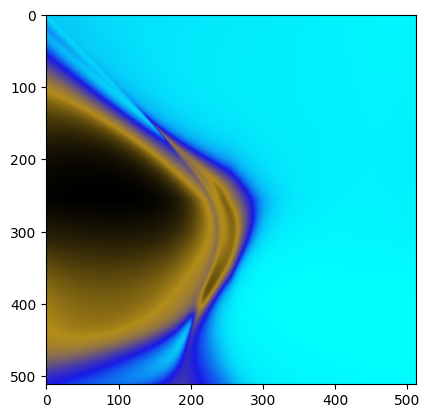

In [47]:
#define a color for each grayscale value, to interpolate
#values: final one must be 1.0, while 0 is always black, the number should go from 0 > 1

values = [0.2,0.7,1.0]

colors = np.array([
    [0.7,0.55,0.1],   #R
    [0.1,0.1,0.9],    #B
    [0,1,1]])         #G

channel = 0

recolors = []
for idx in range(len(preds_normalized)):
  recolors.append([interpolate(i,values,colors) for i in preds_normalized[idx][:,channel]])
  recolors[len(recolors) - 1] = np.array(recolors[len(recolors) - 1])
  recolors[len(recolors) - 1] = recolors[len(recolors) - 1].reshape(ress[idx],ress[idx],3)

  plt.imshow(recolors[len(recolors) - 1])

# Added by MitjaB for dynamic color selection

ColorPicker(value='#ff0000', description='Base Color')

IntSlider(value=255, description='R', max=255)

IntSlider(value=0, description='G', max=255)

IntSlider(value=0, description='B', max=255)

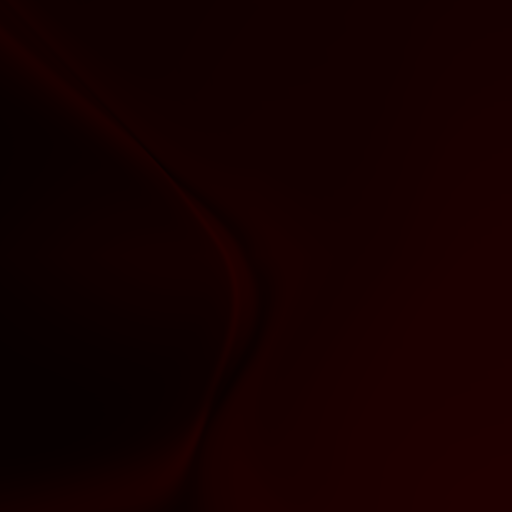

ColorPicker(value='#ff0000', description='Base Color')

IntSlider(value=255, description='R', max=255)

IntSlider(value=0, description='G', max=255)

IntSlider(value=0, description='B', max=255)

In [63]:
from PIL import Image, ImageOps
import ipywidgets as widgets
from IPython.display import display, clear_output

# Helper function to convert hex to RGB
def hex_to_rgb(value):
    value = value.lstrip('#')
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))


def rgb_to_hex(rgb):
    return '#{:02x}{:02x}{:02x}'.format(rgb[0], rgb[1], rgb[2])

def recolor_image(source_img, r, g, b):
    # Convert the image to grayscale
    grayscale = ImageOps.grayscale(source_img)
    grayscale_arr = np.array(grayscale)
    recolored_arr = np.zeros((grayscale_arr.shape[0], grayscale_arr.shape[1], 3), dtype=np.uint8)

    for i in range(256):
        recolored_arr[grayscale_arr == i] = (
            int(r * (i / 255)),
            int(g * (i / 255)),
            int(b * (i / 255)),
        )

    recolored_img = Image.fromarray(recolored_arr)
    return recolored_img


def update_color_picker(change):
    r = r_slider.value
    g = g_slider.value
    b = b_slider.value
    
    # Update the color picker to reflect the new adjusted color
    color_picker.unobserve(update_sliders, names='value')  # Temporarily disable the observer to prevent recursion
    color_picker.value = rgb_to_hex((r, g, b))
    color_picker.observe(update_sliders, names='value')  # Re-enable the observer


def update_images(change):
    clear_output(wait=True)
    for idx in range(len(recolored_imgs)):
      r = r_slider.value
      g = g_slider.value
      b = b_slider.value
      
      recolored_imgs[idx] = recolor_image(recolored_imgs[idx], r, g, b)
    display(color_picker, r_slider, g_slider, b_slider, recolored_imgs[len(recolored_imgs) - 1])

def update_sliders(change):
    rgb = hex_to_rgb(color_picker.value)
    r_slider.value = rgb[0]
    g_slider.value = rgb[1]
    b_slider.value = rgb[2]

# Create color picker
color_picker = widgets.ColorPicker(
    description='Base Color',
    value='#FF0000'
)

# Create sliders for R, G, B adjustments
r_slider = widgets.IntSlider(
    description='R',
    min=0,
    max=255,
    value=0
)
g_slider = widgets.IntSlider(
    description='G',
    min=0,
    max=255,
    value=0
)
b_slider = widgets.IntSlider(
    description='B',
    min=0,
    max=255,
    value=0
)

# Attach the update functions to color picker and slider changes
r_slider.observe(update_color_picker, names='value')
g_slider.observe(update_color_picker, names='value')
b_slider.observe(update_color_picker, names='value')
color_picker.observe(update_sliders, names='value')
color_picker.observe(update_images, names='value')

update_sliders(None)

# Display the widgets and initial image
display(color_picker, r_slider, g_slider, b_slider)

recolored_imgs = []
for idx in range(len(preds_normalized)):
  # Load an image and prepare it
  img_arr = preds_normalized[idx].reshape(ress[idx],ress[idx],3)
  img_arr = (img_arr * 255).astype(np.uint8)
  img = Image.fromarray(img_arr)
  recolored_imgs.append(img)

update_images(None)

## Saving the images in all the sizes

Import the image to Krita for further processing.

In [62]:

from datetime import datetime
import os

SUBFOLDER = "generated_resized_srcs"

if not os.path.exists(SUBFOLDER):
  os.makedirs(SUBFOLDER)

max_id = -1
for file in os.listdir(SUBFOLDER):
  tokenized = os.path.basename(file).split('_')
  if int(tokenized[0]) > max_id:
    max_id = int(tokenized[0])

now = datetime.now()

for idx in range(len(recolored_imgs)):
  img = recolored_imgs[idx]
  
  id_str = now.strftime("%d%m%Y_%H_%M_%S")
  id_str = f'{(max_id + 1)}_{id_str}'
  img.save(f"{SUBFOLDER}/{id_str}_{ress[idx]}x{ress[idx]}.png")